In [1]:
import datetime
from os import path
import math
import collections
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as signal
import core as co
import hist_data as hd

In [2]:
import hist_data as hd

hd.set_hist_data(data_count=None)


Test data size (flats are duducted) is 677512
Test data start time is 2023:01:03 21:34
Test data end time is   2024:10:25 19:00
Subtracting moving avarage: True


forecast:
direction: buy-sell
min profit [PIP]: 7.51
panic value [PIP]: -0.50 - no panic



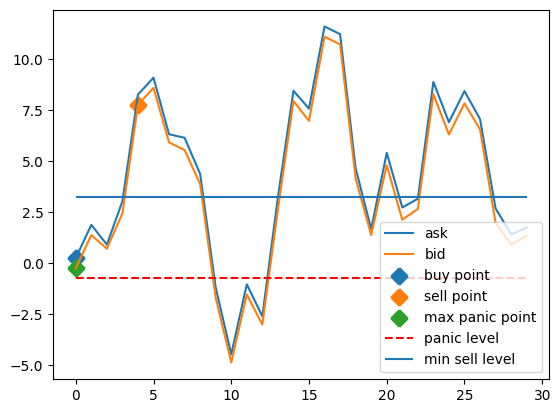

In [3]:
import importlib
import tokenizer as to
import forecast as fo
importlib.reload(fo)
import piecewise_fit as ls
importlib.reload(ls)
importlib.reload(co)

FORECAST_WINDOW = 30
FORECAST_THRESHOLD = 2e-4 + 1e-4 # spread

shift = 1000 # 1400 1500
forecast = fo.Forecast(
    hd.DATA[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD)
print(forecast)
forecast.plot(True)
# [0.000114, 0.000227, 0.000455, 0.00091, 0.00182, 0.00364, 0.00728, 0.0146]


In [8]:
FORECAST_THRESHOLD = co.config.FORECAST_THRESHOLD
PANIC_THRESHOLD = co.config.PANIC_THRESHOLD


In [85]:
dict_data = ((timestamp, value) for timestamp, value in hd.DICT_DATA.items())
prediction, sell_buy_pred, buy_sell_pred, none_pred = fo.get_predictions(verbose=True)

len(sell-buy): 188827 (28%)
len(buy-sell): 237288 (35%)
len(none): 251367 (37%)


In [212]:
def prices(data):
    # 
    timestamp, (timestamp, (ask, bid), volume)  = data
    # print((ask[0], bid[0]))
    return ask[0], bid[0]

def sell_buy(bid_price, ask_price, plot=False):
    sell_price = bid_price
    buy_price = ask_price
    profit = ask_price - sell_price
    time = 0

    bid_price_ = [bid_price]
    ask_price_ = [ask_price]
    profit_ = [profit]
    time_ = [time]


    panic_level = sell_price - PANIC_THRESHOLD

    while True:
        ask_price, bid_price = prices(next(dict_data))
        buy_price = ask_price
        profit = buy_price - sell_price
        time += 1

        bid_price_.append(bid_price)
        ask_price_.append(ask_price)
        profit_.append(profit)
        time_.append(time)
        '''
        First step is to reach the predicted minimal profit level, but abort if
        the predictec panic level is passsed.
        '''
        if profit >= FORECAST_THRESHOLD:
        # if buy_price < panic_level:
            break

    if plot:
        fig, bidask_pl = plt.subplots()
        # print(bid_price_)
        # print(ask_price_)
        bidask_pl.plot(time_, bid_price_, color='blue', label='bid')
        bidask_pl.plot(time_, ask_price_, color='red', label='ask')
        profit_pl = bidask_pl.twinx()
        profit_pl.plot(time_, profit_, color='green', label='profit')
        
        bidask_pl.set_ylabel('bid, ask', color='black')
        profit_pl.set_ylabel('profit', color='green')

        bidask_pl.legend()
        profit_pl.legend()
        plt.show()

    return profit

def buy_sell(ask_price, bid_price, plot=False):
    buy_price = ask_price
    sell_price = bid_price
    profit = buy_price - sell_price
    while True:
        break



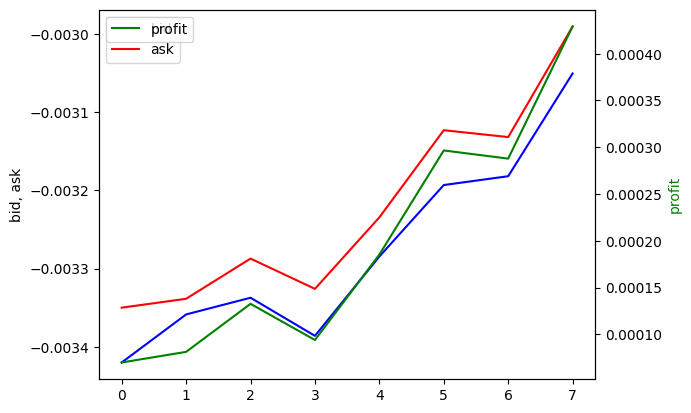

profit: 4.3


In [213]:
while True:
    timestamp_data = next(dict_data)
    if timestamp_data[0] not in prediction:
        continue
    
    ask_price, bid_price = prices(timestamp_data)
    advice, trans_time, panic, max_panic_time = prediction[timestamp_data[0]]
    plot = True
    if advice == fo.Forecast.advices[fo.Forecast.IS_ASK]:
        print(f'profit: {sell_buy(bid_price, ask_price, plot=plot) / fo.Forecast.PIP:.1f}')
        break
    elif advice == fo.Forecast.advices[fo.Forecast.IS_BID]:
        buy_sell(ask_price, bid_price, plot=plot)
    else:
        pass


In [ ]:
data = (1673843280.0, (1673843280.0, ([0.003168468749997322, 0.0032184687499974274, 0.003168468749997322, 0.0032184687499974274], [0.0031384687499973474, 0.003168468749997322, 0.0031184687499974384, 0.003168468749997322]), 120150.0015))
timestamp, (timestamp, bidask_pl, volume) = data
timestamp, (timestamp, (ask, bid), volume) = data
bid

[0.0031384687499973474,
 0.003168468749997322,
 0.0031184687499974384,
 0.003168468749997322]